<center><h1>COL341 Spring 2023<br>Assignment 4: Neural Network</h1>
 <h2>Amaiya Singhal</h2>
 </center>

As mentioned in the assignment, some of the data loading and training code is inspired from here - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# Load CIFAR 10 data

In [38]:
# Define data augmentation for train
train_transform = transform = transforms.Compose([
        transforms.RandomHorizontalFlip(), # augementation
        transforms.RandomRotation(10), # augmentation
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

val_transform =  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Get train and test dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=val_transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [39]:
print(f"Training data shape: {len(trainset)}")
print(f"Test data shape: {len(valset)}")

Training data shape: 50000
Test data shape: 10000


# Plot random training set examples

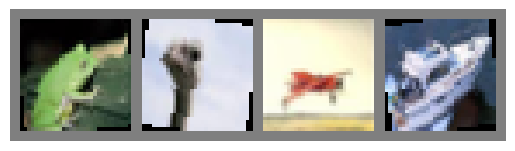

frog  bird  plane ship 


In [40]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# get some random training images
n = 4
dataiter = np.random.choice(len(trainset), replace=False, size=n)
images, labels = [trainset[i][0] for i in dataiter], [trainset[i][1] for i in dataiter]

# show images
imshow(torchvision.utils.make_grid(images, padding=3))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(n)))

# 4 Part 3: Improving the CNN


## Model 1

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(64*3*3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x        

In [41]:
class Experiment:
    """
    Runs a training experiment, given an appropriate config dictionary.
    Allows repeatable experiments by just changing a few hyperparameters.
    """
    def __init__(self, config):
        """
        Takes a config as input that contains the keys:
        epochs: Specifies number of epochs to train the model for (default 20)
        lr: Learning rate for the optimizer (default 0.001)
        batch_size: Number of images to comprise a minibatch (default 32)
        optimizer: Choose from 'adam' or 'sgd'
        criterion: Choose from 'cross_entropy' or 'kl_divergence'
        lr_scheduler: True or False value to specify usage of the MultiStepLR lr scheduler.
        """
        self.config = config
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.epochs = config.get("epochs", 20)
        self.lr = config.get("lr", 0.001)
        self.batch_size = config.get("batch_size", 32)
        self.model = CNN().to(self.device)
    
        # Define optimizer
        opt = config.get("optimizer", "adam")
        if opt.lower() == "adam":
            self.config["optimizer"] = "adam"
            self.optimizer = optim.Adam(self.model.parameters(), lr = self.lr)
        else:
            self.config["optimizer"] = "sgd"
            self.optimizer = optim.SGD(self.model.parameters(), lr = self.lr)
            
        # Define criterion
        crit = config.get("criterion", "cross_entropy")
        if crit.lower() == "cross_entropy":
            self.config["criterion"] = "cross_entropy"
            self.criterion = nn.CrossEntropyLoss()
        else:
            self.config["criterion"] = "kl_divergence"
            self.criterion = nn.KLDivLoss(reduction="batchmean")
        
        # Define train and val dataloaders
        self.trainloader = torch.utils.data.DataLoader(trainset, 
                                                       batch_size=self.batch_size, 
                                                       shuffle=True, 
                                                       num_workers=0)
        self.valloader = torch.utils.data.DataLoader(valset, 
                                                batch_size=self.batch_size, 
                                                shuffle=False, 
                                                num_workers=0)
        
        # Define learning rate scheduler
        lr_scheduler = config.get("lr_scheduler", False)
        if lr_scheduler:
            self.config["lr_scheduler"] = "MultiStepLR"
            self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, 
                                        milestones=[10, 15, 20], # List of epoch indices
                                        gamma =0.5)
        else:
            self.config["lr_scheduler"] = False
            self.scheduler = None
            
        self.train_losses, self.val_losses = [], []
        self.train_acc, self.val_acc = [], []
        self.val_classwise_accuracy = {classname: [0,0] for classname in classes}
                
    def get_classwise_val_accuracy(self):
        print(f"Classwise accuracies on validation set after epoch {self.epochs} -")
        for classname, counts in self.val_classwise_accuracy.items():
            accuracy = 100 * float(counts[0]) / counts[1]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
        
    def _run_validation(self, cur_epoch):
        with torch.no_grad():
            running_val_loss, val_correct = 0.0, 0
            for val_data in self.valloader:
                val_inputs, val_labels = val_data[0].to(self.device), val_data[1].to(self.device)
                val_outputs = self.model(val_inputs)
                
                # KL divergence loss needs preds and targets as probability distributions
                if self.config["criterion"] == "kl_divergence":
                    val_loss = self.criterion(F.log_softmax(val_outputs, dim=1), 
                                              F.one_hot(val_labels, num_classes=len(classes)).float())
                else:
                    val_loss = self.criterion(val_outputs, val_labels)
                    
                running_val_loss += val_loss.item()
                val_preds = torch.argmax(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()

                # Save classwise accuracy for last epoch
                if cur_epoch == self.epochs:
                    for l, p in zip(val_labels, val_preds):
                        if l == p:
                            self.val_classwise_accuracy[classes[l]][0] += 1
                        self.val_classwise_accuracy[classes[l]][1] += 1
                        
        return running_val_loss/len(self.valloader), val_correct/len(valset)
    
    def plot_graphs(self):
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f"LR = {self.lr}, Optimizer = {self.config['optimizer']}", fontsize=16)
        ax0 = fig.add_subplot(121, title="Loss")
        ax0.plot(np.arange(len(self.train_losses)), self.train_losses, 'bo-', label = "Train")
        ax0.plot(np.arange(len(self.val_losses)), self.val_losses, 'ro-', label = "Val")
        ax0.set_xlabel("Epoch")
        ax0.set_ylabel("Loss value")
        ax0.legend()
        
        ax1 = fig.add_subplot(122, title="Accuracy")
        ax1.plot(np.arange(len(self.train_acc)), self.train_acc, 'bo-', label = "Train")
        ax1.plot(np.arange(len(self.val_acc)), self.val_acc, 'ro-', label = "Val")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Accuracy (%)")
        ax1.legend()
        plt.show()
        
                
    def run_experiment(self):
        print("Running experiment with -")
        for key in self.config:
            print(f"  {key}: {self.config[key]}")
        print("----------------------------")
        
        for epoch in range(self.epochs):
            running_loss, running_correct = 0.0, 0
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data[0].to(self.device), data[1].to(self.device)
                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                
                # KL divergence loss needs preds and targets as probability distributions
                if self.config["criterion"] == "kl_divergence":
                    loss = self.criterion(F.log_softmax(outputs, dim=1), 
                                          F.one_hot(labels, num_classes=len(classes)).float())
                else:
                    loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                preds = torch.argmax(outputs, 1)
                running_correct += (preds == labels).sum().item()
            
            if self.config["lr_scheduler"]:
                self.scheduler.step()

            train_loss, train_acc = running_loss/len(self.trainloader), running_correct/len(trainset)
            
            # Run validation after every epoch
            val_loss, val_accuracy = self._run_validation(cur_epoch = epoch+1)
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_acc.append(train_acc*100)
            self.val_acc.append(val_accuracy*100)
            print(f"Epoch: {epoch+1} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f} | Val loss: {val_loss:.3f} |  Val acc: {val_accuracy:.3f}")
            if self.config["lr_scheduler"]:
                print(f"Epoch: {epoch+1} | Learning rate: {self.optimizer.param_groups[0]['lr']}")
        print('Finished Training')

## Testing on Model 1

In [29]:
exp = Experiment(config={"epochs": 20,
                          "lr": 0.001,
                          "batch_size": 32,
                          "optimizer": "adam",
                          "lr_scheduler": True})
exp.run_experiment()

Running experiment with -
  epochs: 20
  lr: 0.001
  batch_size: 32
  optimizer: adam
  lr_scheduler: MultiStepLR
  criterion: cross_entropy
----------------------------
Epoch: 1 | Train loss: 1.551 | Train acc: 0.424 | Val loss: 1.334 |  Val acc: 0.517
Epoch: 1 | Learning rate: 0.001
Epoch: 2 | Train loss: 1.192 | Train acc: 0.571 | Val loss: 1.087 |  Val acc: 0.615
Epoch: 2 | Learning rate: 0.001
Epoch: 3 | Train loss: 1.056 | Train acc: 0.625 | Val loss: 0.984 |  Val acc: 0.652
Epoch: 3 | Learning rate: 0.001
Epoch: 4 | Train loss: 0.968 | Train acc: 0.660 | Val loss: 0.944 |  Val acc: 0.665
Epoch: 4 | Learning rate: 0.001
Epoch: 5 | Train loss: 0.902 | Train acc: 0.683 | Val loss: 0.872 |  Val acc: 0.693
Epoch: 5 | Learning rate: 0.001
Epoch: 6 | Train loss: 0.859 | Train acc: 0.699 | Val loss: 0.863 |  Val acc: 0.696
Epoch: 6 | Learning rate: 0.001
Epoch: 7 | Train loss: 0.825 | Train acc: 0.711 | Val loss: 0.831 |  Val acc: 0.710
Epoch: 7 | Learning rate: 0.001
Epoch: 8 | Train l

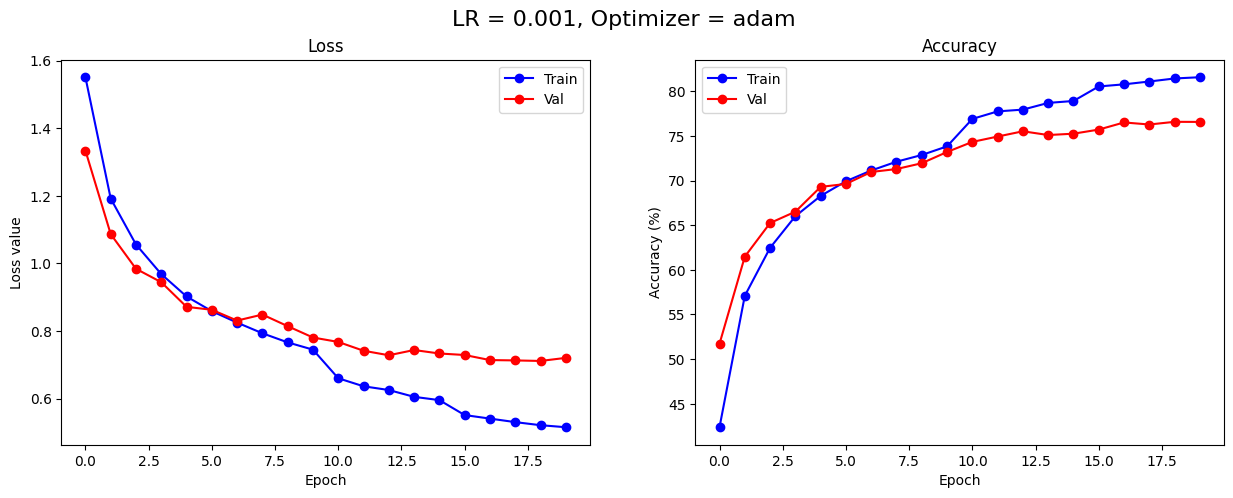

In [30]:
exp.plot_graphs()

In [31]:
exp.get_classwise_val_accuracy()

Classwise accuracies on validation set after epoch 20 -
Accuracy for class: plane is 82.9 %
Accuracy for class: car   is 86.1 %
Accuracy for class: bird  is 58.3 %
Accuracy for class: cat   is 56.7 %
Accuracy for class: deer  is 77.7 %
Accuracy for class: dog   is 70.0 %
Accuracy for class: frog  is 85.0 %
Accuracy for class: horse is 82.4 %
Accuracy for class: ship  is 85.4 %
Accuracy for class: truck is 81.3 %


**Observation:** The accuracy has improved to 76.6%

## Model 2

In [72]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*3*3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)
        self.dropout = nn.Dropout(p=0.1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = F.relu(self.batch1(x))
        # x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        # x = self.batch2(x)
        # x = F.relu(x)
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        # x = self.batch2
        # x = F.relu(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x       

## Testing on Model 2

In [73]:
exp = Experiment(config={"epochs": 30,
                          "lr": 0.001,
                          "batch_size": 32,
                          "optimizer": "adam",
                          "lr_scheduler": True})
exp.run_experiment()

Running experiment with -
  epochs: 30
  lr: 0.001
  batch_size: 32
  optimizer: adam
  lr_scheduler: MultiStepLR
  criterion: cross_entropy
----------------------------
Epoch: 1 | Train loss: 1.675 | Train acc: 0.376 | Val loss: 1.348 |  Val acc: 0.511
Epoch: 1 | Learning rate: 0.001
Epoch: 2 | Train loss: 1.285 | Train acc: 0.538 | Val loss: 1.179 |  Val acc: 0.579
Epoch: 2 | Learning rate: 0.001
Epoch: 3 | Train loss: 1.142 | Train acc: 0.593 | Val loss: 1.082 |  Val acc: 0.620
Epoch: 3 | Learning rate: 0.001
Epoch: 4 | Train loss: 1.051 | Train acc: 0.632 | Val loss: 1.014 |  Val acc: 0.645
Epoch: 4 | Learning rate: 0.001
Epoch: 5 | Train loss: 0.991 | Train acc: 0.656 | Val loss: 0.971 |  Val acc: 0.661
Epoch: 5 | Learning rate: 0.001
Epoch: 6 | Train loss: 0.940 | Train acc: 0.672 | Val loss: 0.918 |  Val acc: 0.680
Epoch: 6 | Learning rate: 0.001
Epoch: 7 | Train loss: 0.906 | Train acc: 0.686 | Val loss: 0.877 |  Val acc: 0.701
Epoch: 7 | Learning rate: 0.001
Epoch: 8 | Train l

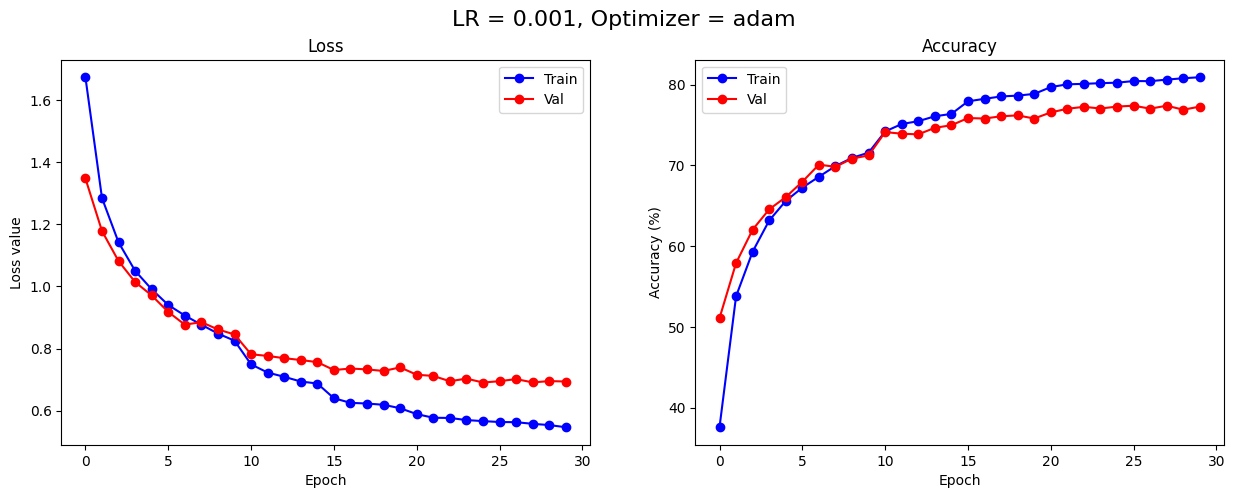

In [74]:
exp.plot_graphs()

In [75]:
exp.get_classwise_val_accuracy()

Classwise accuracies on validation set after epoch 30 -
Accuracy for class: plane is 82.2 %
Accuracy for class: car   is 88.4 %
Accuracy for class: bird  is 71.2 %
Accuracy for class: cat   is 62.6 %
Accuracy for class: deer  is 72.9 %
Accuracy for class: dog   is 59.9 %
Accuracy for class: frog  is 83.2 %
Accuracy for class: horse is 78.5 %
Accuracy for class: ship  is 86.6 %
Accuracy for class: truck is 87.3 %
